In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import math as math
from sklearn import *
from math import *
from numpy.linalg import norm
%matplotlib inline
import matplotlib.pyplot as plt
import datetime

C:\Program Files (x86)\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Program Files (x86)\Anaconda3\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
C:\Program Files (x86)\Anaconda3\lib\site-packages\sklearn\lda.py:4: DeprecationWarning: lda.LDA has been moved to discriminant_analysis.LinearDiscriminantAnalysis in 0.17 and will be removed in 0.19
  "in 0.17 and will be removed in 0.19", DeprecationWarnin

In [2]:
#Train

train = pd.read_csv('train.csv', delimiter=',', index_col='datetime', parse_dates=True)
#train.describe()

train['year'] = train.index.year
train['month'] = train.index.month
train['hour'] = train.index.hour
train['day'] = train.index.weekday

season = train['month']
season = season.apply(lambda s: 4 if int(s) == 1 or int(s) == 2 else (int(s) - 3) // 3 + 1)   
train = train.drop('season', axis = 1)
train.insert(5, 'season', season)

hour = train['hour']
mainHour = np.arange(hour.shape[0])
mainHour = [1 if (hour[i] == 7) or (hour[i] == 8) or (hour[i] == 17) or (hour[i] == 18) else 0 for i in range(hour.shape[0])]
train['mainHour'] = mainHour

train.head(5)

,holiday,workingday,weather,temp,atemp,season,humidity,windspeed,casual,registered,count,year,month,hour,day,mainHour
datetime,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,0,0,1,9.84,14.395,4,81,0.0,3,13,16,2011,1,0,5,0
2011-01-01 01:00:00,0,0,1,9.02,13.635,4,80,0.0,8,32,40,2011,1,1,5,0
2011-01-01 02:00:00,0,0,1,9.02,13.635,4,80,0.0,5,27,32,2011,1,2,5,0
2011-01-01 03:00:00,0,0,1,9.84,14.395,4,75,0.0,3,10,13,2011,1,3,5,0
2011-01-01 04:00:00,0,0,1,9.84,14.395,4,75,0.0,0,1,1,2011,1,4,5,0


In [3]:
#Test
 
test = pd.read_csv('test.csv', delimiter=',', index_col='datetime', parse_dates=True)
#test.describe()

test['year'] = test.index.year
test['month'] = test.index.month
test['hour'] = test.index.hour
test['day'] = test.index.weekday

season = test['month']
season = season.apply(lambda s: 4 if int(s) == 1 or int(s) == 2 else (int(s) - 3) // 3 + 1)   
test = test.drop('season', axis = 1)
test.insert(5, 'season', season)

hour = test['hour']
mainHour = np.arange(hour.shape[0])
mainHour = [1 if (hour[i] == 7) or (hour[i] == 8) or (hour[i] == 17) or (hour[i] == 18) else 0 for i in range(hour.shape[0])]
test['mainHour'] = mainHour

test.head(5)

,holiday,workingday,weather,temp,atemp,season,humidity,windspeed,year,month,hour,day,mainHour
datetime,,,,,,,,,,,,,
2011-01-20 00:00:00,0,1,1,10.66,11.365,4,56,26.0027,2011,1,0,3,0
2011-01-20 01:00:00,0,1,1,10.66,13.635,4,56,0.0000,2011,1,1,3,0
2011-01-20 02:00:00,0,1,1,10.66,13.635,4,56,0.0000,2011,1,2,3,0
2011-01-20 03:00:00,0,1,1,10.66,12.880,4,56,11.0014,2011,1,3,3,0
2011-01-20 04:00:00,0,1,1,10.66,12.880,4,56,11.0014,2011,1,4,3,0


In [4]:
# 0.43532   **2  или *2 все равно, один рез-т
train['hour2'] = (train['hour'])*2
test['hour2'] = (test['hour'])*2

# 0.43756
# train['temp2'] = (train['temp'])**2
# test['temp2'] = (test['temp'])**2

# 0.47908
#train['dif'] = (train['temp'] - train['hour'])**2
#test['dif'] = (test['temp'] - test['hour'])**2
#
# train['hum2'] = (train['humidity'])*2
# test['hum2'] = (test['humidity'])*2

# 0.43756
# train['dif'] = (train['atemp'] - train['temp'])**2
# test['dif'] = (test['atemp'] - test['temp'])**2

train['dif'] = (train['windspeed'] - train['atemp'])**2 
test['dif'] = (test['windspeed'] - test['atemp'])**2

X = train.drop(['mainHour', 'casual', 'registered', 'count'], axis = 1)
Xr = train.drop(['casual', 'registered', 'count'], axis = 1)
X_test = test.drop(['mainHour'], axis = 1)
Xr_test = test

In [5]:
maxDepth = 10
nEstimators = 120
subSample = 0.9

y = np.log(train['casual'] + 1)
xgb_model = xgb.XGBRegressor(max_depth = maxDepth, n_estimators = nEstimators, subsample = subSample).fit(X,y)

predictions1 = np.exp(xgb_model.predict(X)) - 1
#-----------------------------------
y = np.log(train['registered'] + 1)
xgb_model = xgb.XGBRegressor(max_depth = maxDepth, n_estimators = nEstimators, subsample = subSample).fit(Xr,y)

predictions2 = np.exp(xgb_model.predict(Xr)) - 1
#-----------------------------------
y = train['count']
predictions = predictions1 + predictions2
predictions = np.round(predictions)

print(min(abs(predictions - y)))
print(math.sqrt(1 / len(y) * sum((np.log(predictions + 1) - np.log(y + 1))**2)))
print(max(abs(predictions - y)))
print(len([elem for elem in (abs(predictions - y) / y) if elem < 0.1]), train.shape[0])

0.0
0.07460395101178144
175.0
9457 10886


In [6]:
y = np.log(train['casual'] + 1)

xgb_model = xgb.XGBRegressor(max_depth = maxDepth, n_estimators = nEstimators, subsample = subSample).fit(X,y)
predictions1 = np.exp(xgb_model.predict(X_test)) - 1
#--------------------------
y = np.log(train['registered'] + 1)

xgb_model = xgb.XGBRegressor(max_depth = maxDepth, n_estimators = nEstimators, subsample = subSample).fit(Xr,y)
predictions2 = np.exp(xgb_model.predict(Xr_test)) - 1
#--------------------------
predictions = predictions1 + predictions2
predictions = np.round(predictions)
predictions = [0 if predictions[i] < 0.01 else predictions[i] for i in range(predictions.shape[0])]

test.insert(len(test.columns), 'count', predictions)
test.head(10)

,holiday,workingday,weather,temp,atemp,season,humidity,windspeed,year,month,hour,day,mainHour,hour2,dif,count
datetime,,,,,,,,,,,,,,,,
2011-01-20 00:00:00,0,1,1,10.66,11.365,4,56,26.0027,2011,1,0,3,0,0,214.262261,12.0
2011-01-20 01:00:00,0,1,1,10.66,13.635,4,56,0.0000,2011,1,1,3,0,2,185.913225,5.0
2011-01-20 02:00:00,0,1,1,10.66,13.635,4,56,0.0000,2011,1,2,3,0,4,185.913225,3.0
2011-01-20 03:00:00,0,1,1,10.66,12.880,4,56,11.0014,2011,1,3,3,0,6,3.529138,2.0
2011-01-20 04:00:00,0,1,1,10.66,12.880,4,56,11.0014,2011,1,4,3,0,8,3.529138,2.0
2011-01-20 05:00:00,0,1,1,9.84,11.365,4,60,15.0013,2011,1,5,3,0,10,13.222678,6.0
2011-01-20 06:00:00,0,1,1,9.02,10.605,4,60,15.0013,2011,1,6,3,0,12,19.327454,34.0
2011-01-20 07:00:00,0,1,1,9.02,10.605,4,55,15.0013,2011,1,7,3,1,14,19.327454,85.0
2011-01-20 08:00:00,0,1,1,9.02,10.605,4,55,19.0012,2011,1,8,3,1,16,70.496174,194.0


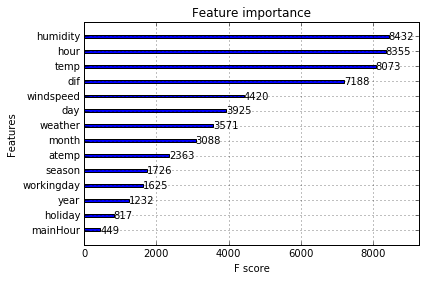

In [7]:
xgb.plot_importance(xgb_model)

In [8]:
newny = pd.DataFrame(test.index)
newny.insert(1, 'count', predictions)
newny.head(20)

,datetime,count
0,2011-01-20 00:00:00,12.0
1,2011-01-20 01:00:00,5.0
2,2011-01-20 02:00:00,3.0
3,2011-01-20 03:00:00,2.0
4,2011-01-20 04:00:00,2.0
5,2011-01-20 05:00:00,6.0
6,2011-01-20 06:00:00,34.0
7,2011-01-20 07:00:00,85.0
8,2011-01-20 08:00:00,194.0
9,2011-01-20 09:00:00,116.0


In [9]:
newny.to_csv('submission.csv', sep=',', header = True, index = False)